# GalaxyPPG — EDA, Wearable Signal Processing & QC

End-to-end exploration of the standardized GalaxyPPG dataset: PPG + 3-axis
accelerometer from a Galaxy Watch, with Polar-derived HR labels.

This notebook has two threads running in parallel:

- **Classic SciPy baseline** — explicit `scipy.signal` calls for filtering,
  PSD, peak-based HR estimation. Good for building intuition and
  establishing a signal-processing floor.

- **Repo operators (training parity)** — the same transforms the training
  pipeline applies, loaded directly from the YAML config. Ensures the
  notebook and the training loop see the same preprocessed data.

The dataset lives at `data/standardized/galaxyppg/v1/` with the usual
layout: `subjects/*.npz`, `views/windows.parquet`, `views/subjects.parquet`,
`meta.json`, `stats.json`.


In [29]:
# ── Imports & paths ──────────────────────────────────────────────────────────

from __future__ import annotations

import json
import os
import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from scipy import signal

    HAS_SCIPY = True
except ImportError:
    signal = None
    HAS_SCIPY = False
    print("SciPy not available — filtering / PSD / peak cells will be limited.")


# Repo root discovery
def _find_repo_root(start: Path) -> Path:
    env = os.environ.get("BIOSIGNALS_REPO_ROOT", "").strip()
    if env:
        p = Path(env).expanduser().resolve()
        if (p / "pyproject.toml").exists() and (p / "src" / "biosignals").exists():
            return p
    for p in (start.resolve(), *start.resolve().parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "biosignals").exists():
            return p
    raise RuntimeError(
        f"Could not find repo root from {start}. "
        "Launch Jupyter from repo root or set BIOSIGNALS_REPO_ROOT."
    )


REPO_ROOT = _find_repo_root(Path.cwd())
SRC_DIR = (REPO_ROOT / "src").resolve()
sys.path = [str(SRC_DIR)] + [p for p in sys.path if p != str(SRC_DIR)]

# Purge stale imports
for k in list(sys.modules):
    if k == "biosignals" or k.startswith("biosignals."):
        del sys.modules[k]

# Repo-local imports (graceful fallback)
WindowedNpzDataset = build_transform = OmegaConf = None
Sample = EnsureFloat32 = ZScorePerChannel = BandpassButter = NotchFilter = None
ResampleToPrimary = Compose = None

try:
    from omegaconf import OmegaConf

    from biosignals.data.datasets.windowed_npz import WindowedNpzDataset
    from biosignals.data.transforms.compose import Compose
    from biosignals.data.transforms.factory import build_transform
    from biosignals.data.transforms.resample import ResampleToPrimary
    from biosignals.data.transforms.signal_ops import (
        BandpassButter,
        EnsureFloat32,
        ZScorePerChannel,
    )
    from biosignals.data.types import Sample

    print("Repo biosignals imported OK.")
except Exception as e:
    print(f"Repo transforms not available (EDA cells still work): {e!r}")

# Dataset root
DATA_STD_DIR = Path(os.environ.get("DATA_STD_DIR", REPO_ROOT / "data" / "standardized")).resolve()
GALAXY_ROOT = DATA_STD_DIR / "galaxyppg" / "v1"

# print("REPO_ROOT   :", REPO_ROOT)
# print("GALAXY_ROOT :", GALAXY_ROOT)
assert GALAXY_ROOT.exists(), f"Dataset root not found: {GALAXY_ROOT}"

plt.rcParams["figure.figsize"] = (12, 4)
random.seed(0)
np.random.seed(0)

Repo biosignals imported OK.


In [2]:
# ── Dataset metadata ─────────────────────────────────────────────────────────

meta = json.loads((GALAXY_ROOT / "meta.json").read_text())
stats = json.loads((GALAXY_ROOT / "stats.json").read_text())
split_map = json.loads((GALAXY_ROOT / "views" / "splits.json").read_text())

windows = pd.read_parquet(GALAXY_ROOT / "views" / "windows.parquet")
subjects = pd.read_parquet(GALAXY_ROOT / "views" / "subjects.parquet")

print(f"Dataset: {meta.get('dataset')} {meta.get('version')}")
print(f"fs_out: {meta.get('fs_out')} | window: {meta.get('window')}")
print(f"n_subjects: {meta.get('n_subjects')} | n_windows: {meta.get('n_windows')}")
print(f"PPG mean/std: {stats['ppg']['mean']} / {stats['ppg']['std']}")
print(f"ACC mean/std: {stats['acc']['mean']} / {stats['acc']['std']}")
print(f"\nwindows: {windows.shape} | subjects: {subjects.shape}")
windows.head()

Dataset: galaxyppg v1
fs_out: 64.0 | window: {'length_s': 8.0, 'shift_s': 2.0}
n_subjects: 23 | n_windows: 35417
PPG mean/std: [1896142.230449396] / [302201.49453672377]
ACC mean/std: [0.5689521045169629, -3.8996354042910717, 4.159104429725083] / [5.071685551822778, 6.641241181194821, 4.281053318133843]

windows: (35417, 16) | subjects: (23, 10)


,dataset,version,subject_id,window_idx,start_idx,end_idx,t_start_ms,t_end_ms,t_center_ms,hr,session_id,session,tsst,ssst,fs,split
0,galaxyppg,v1,P02,0,0,512,1.710812e+12,1.710812e+12,1.710812e+12,84.103023,0,adaptation,5,6,64.0,test
1,galaxyppg,v1,P02,1,128,640,1.710812e+12,1.710812e+12,1.710812e+12,84.973332,0,adaptation,5,6,64.0,test
2,galaxyppg,v1,P02,2,256,768,1.710812e+12,1.710812e+12,1.710812e+12,83.890792,0,adaptation,5,6,64.0,test
3,galaxyppg,v1,P02,3,384,896,1.710812e+12,1.710812e+12,1.710812e+12,83.000000,0,adaptation,5,6,64.0,test
4,galaxyppg,v1,P02,4,512,1024,1.710812e+12,1.710812e+12,1.710812e+12,83.000000,0,adaptation,5,6,64.0,test


## View-level EDA

Splits, sessions, and the HR label distribution. GalaxyPPG records come
from multiple experimental sessions (baseline, TSST stress, etc.), so
session balance matters for generalization.


Splits:
split
train    24635
test      6059
val       4723
Name: count, dtype: int64

Sessions (top 10):
session
adaptation         3440
meditation-1       3370
meditation-2       3368
tsst-speech        2006
screen-reading     2002
mobile-typing      1988
standing           1987
keyboard-typing    1986
baseline           1979
tsst-prep          1978
Name: count, dtype: int64

HR summary (bpm):
count    35417.000000
mean        87.755592
std         21.709289
min         56.000000
1%          62.000000
5%          67.000000
50%         81.215684
95%        140.481365
99%        172.000000
max        191.000000
Name: hr, dtype: float64


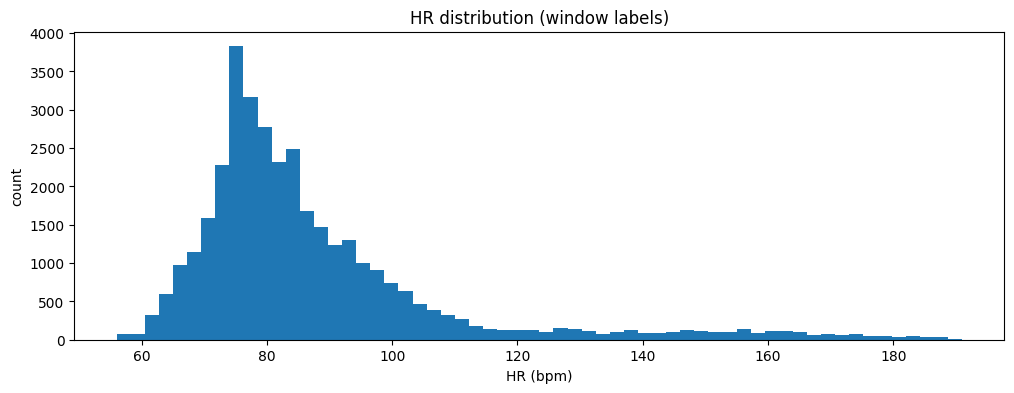


TSST distribution:
tsst
3     9221
4     4662
5    16936
6     4598
Name: count, dtype: int64

SSST distribution:
ssst
1    3022
2    1504
3    2980
4    9373
5    6057
6    9354
7    3127
Name: count, dtype: int64


In [3]:
print("Splits:")
print(windows["split"].value_counts(dropna=False))

if "session" in windows.columns:
    print("\nSessions (top 10):")
    print(windows["session"].value_counts(dropna=False).head(10))

if "hr" in windows.columns:
    hr = windows["hr"].astype(float)
    print("\nHR summary (bpm):")
    print(hr.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

    plt.figure()
    plt.hist(hr.dropna(), bins=60)
    plt.title("HR distribution (window labels)")
    plt.xlabel("HR (bpm)")
    plt.ylabel("count")
    plt.show()

for c in ["tsst", "ssst"]:
    if c in windows.columns:
        print(f"\n{c.upper()} distribution:")
        print(windows[c].value_counts(dropna=False).sort_index())

  subject_id    fs  n_samples   duration_s  n_windows  tsst  ssst  has_events  \
0        P02  64.0     232130  3627.031250       1525     5     6        True   
1        P03  64.0     234940  3670.937500       1511     4     6        True   
2        P04  64.0     231995  3624.921875       1575     5     6        True   
3        P05  64.0     238477  3726.203125       1497     5     6        True   
4        P06  64.0     228576  3571.500000       1532     3     5        True   

   has_polar_hr  split  
0          True   test  
1          True   test  
2          True    val  
3          True  train  
4          True    val  

Subjects per split:
split
train    16
test      4
val       3
Name: count, dtype: int64


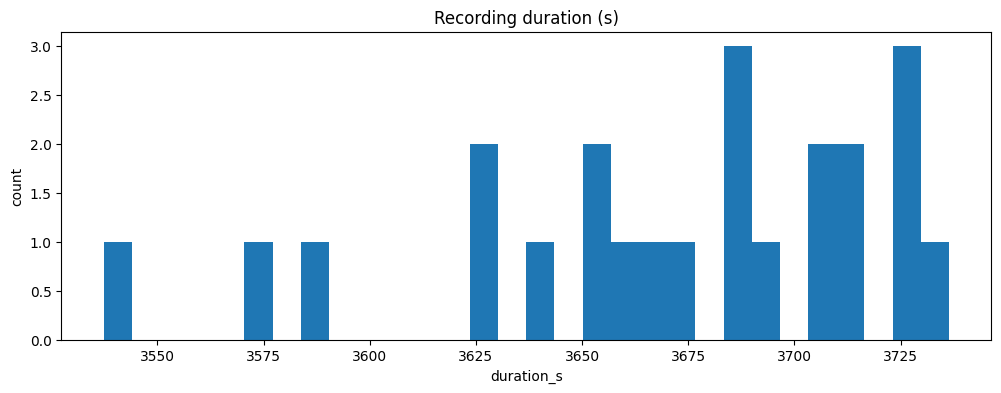

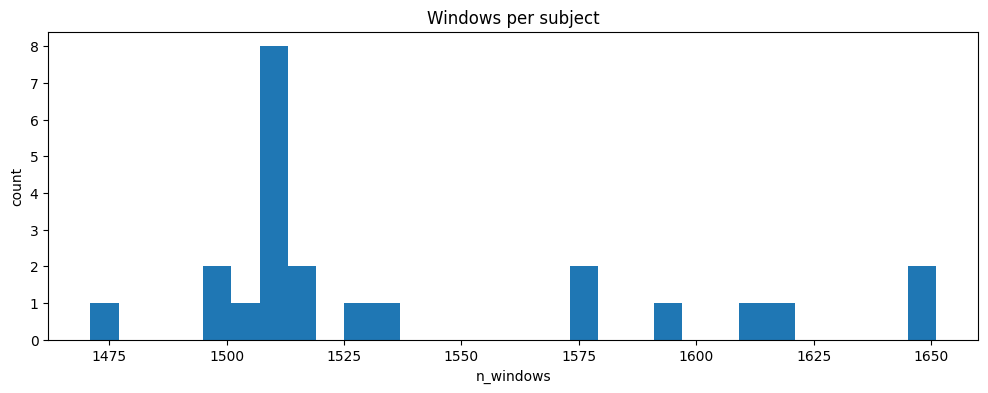

In [4]:
# Subject-level
print(subjects.head())
if "split" in subjects.columns:
    print("\nSubjects per split:")
    print(subjects["split"].value_counts(dropna=False))

for col, title in [("duration_s", "Recording duration (s)"), ("n_windows", "Windows per subject")]:
    if col in subjects.columns:
        plt.figure()
        plt.hist(subjects[col].astype(float), bins=30)
        plt.title(title)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

## Raw PPG + accelerometer

Each subject NPZ stores aligned PPG (1, T) and ACC (3, T) at a common
sample rate. Quick look at a raw segment and a labeled window.


In [5]:
SUBJECT_ID = "P02"
npz_path = GALAXY_ROOT / "subjects" / f"{SUBJECT_ID}.npz"
assert npz_path.exists(), f"Missing: {npz_path}"

with np.load(npz_path, allow_pickle=False) as z:
    subj = {k: z[k] for k in z.files}

for k, v in subj.items():
    print(f"  {k:8s} shape={v.shape} dtype={v.dtype}")

fs = float(np.asarray(subj["fs"]).reshape(-1)[0])
ppg = subj["ppg"]  # (1, T)
acc = subj["acc"]  # (3, T)
T = ppg.shape[-1]
print(f"\nfs: {fs} Hz | samples: {T} | duration: {T/fs/60:.1f} min")

  ppg      shape=(1, 232130) dtype=float32
  acc      shape=(3, 232130) dtype=float32
  session_id shape=(232130,) dtype=int16
  t_ms     shape=(232130,) dtype=float64
  fs       shape=(1,) dtype=float32

fs: 64.0 Hz | samples: 232130 | duration: 60.5 min


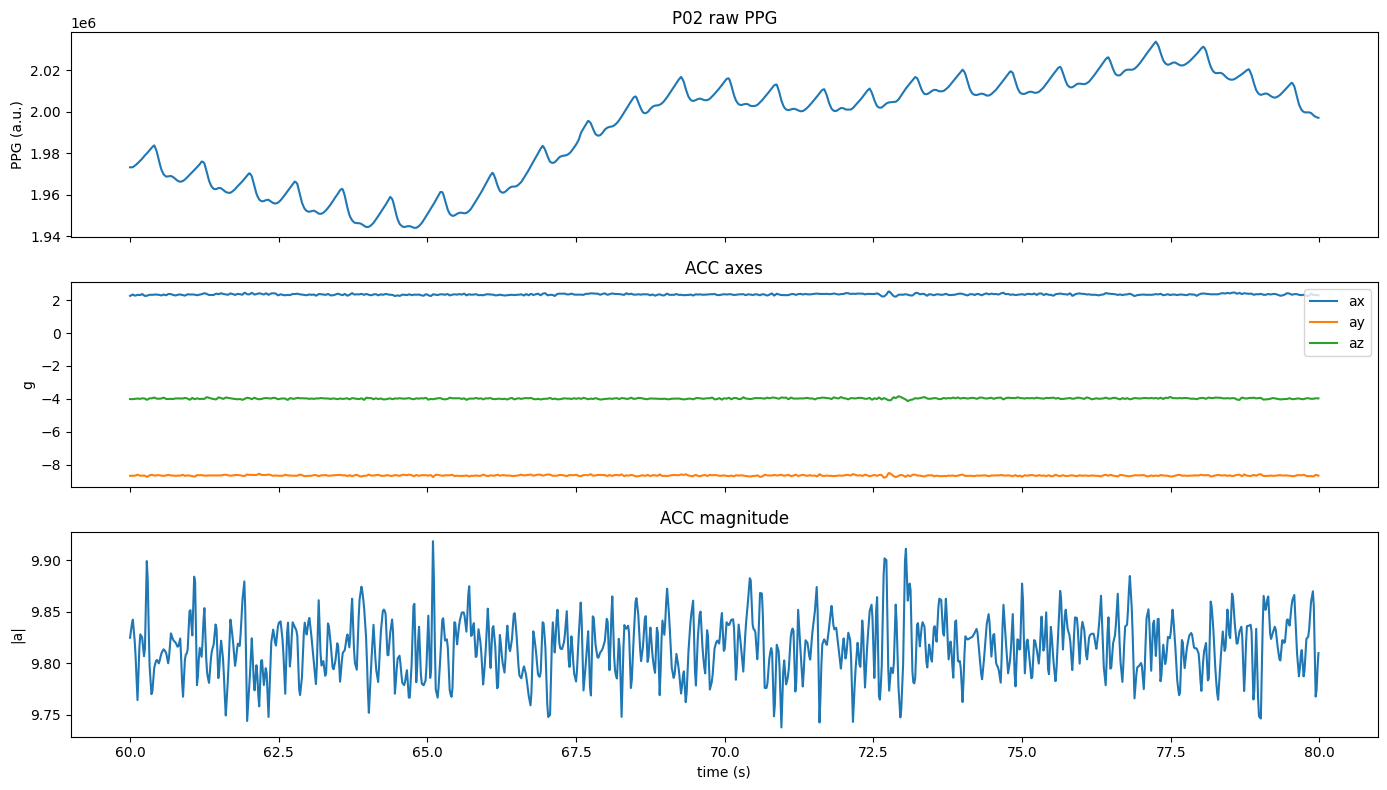

In [6]:
# Raw segment (20 s starting at t=60 s)
t0_s, seg_s = 60.0, 20.0
i0, i1 = int(t0_s * fs), min(T, int((t0_s + seg_s) * fs))
t = np.arange(i0, i1) / fs
acc_mag = np.linalg.norm(acc[:, i0:i1], axis=0)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(14, 8))
ax[0].plot(t, ppg[0, i0:i1])
ax[0].set_title(f"{SUBJECT_ID} raw PPG")
ax[0].set_ylabel("PPG (a.u.)")
for j, lbl in enumerate(["ax", "ay", "az"]):
    ax[1].plot(t, acc[j, i0:i1], label=lbl)
ax[1].set_title("ACC axes")
ax[1].set_ylabel("g")
ax[1].legend(loc="upper right")
ax[2].plot(t, acc_mag)
ax[2].set_title("ACC magnitude")
ax[2].set_ylabel("|a|")
ax[2].set_xlabel("time (s)")
plt.tight_layout()
plt.show()

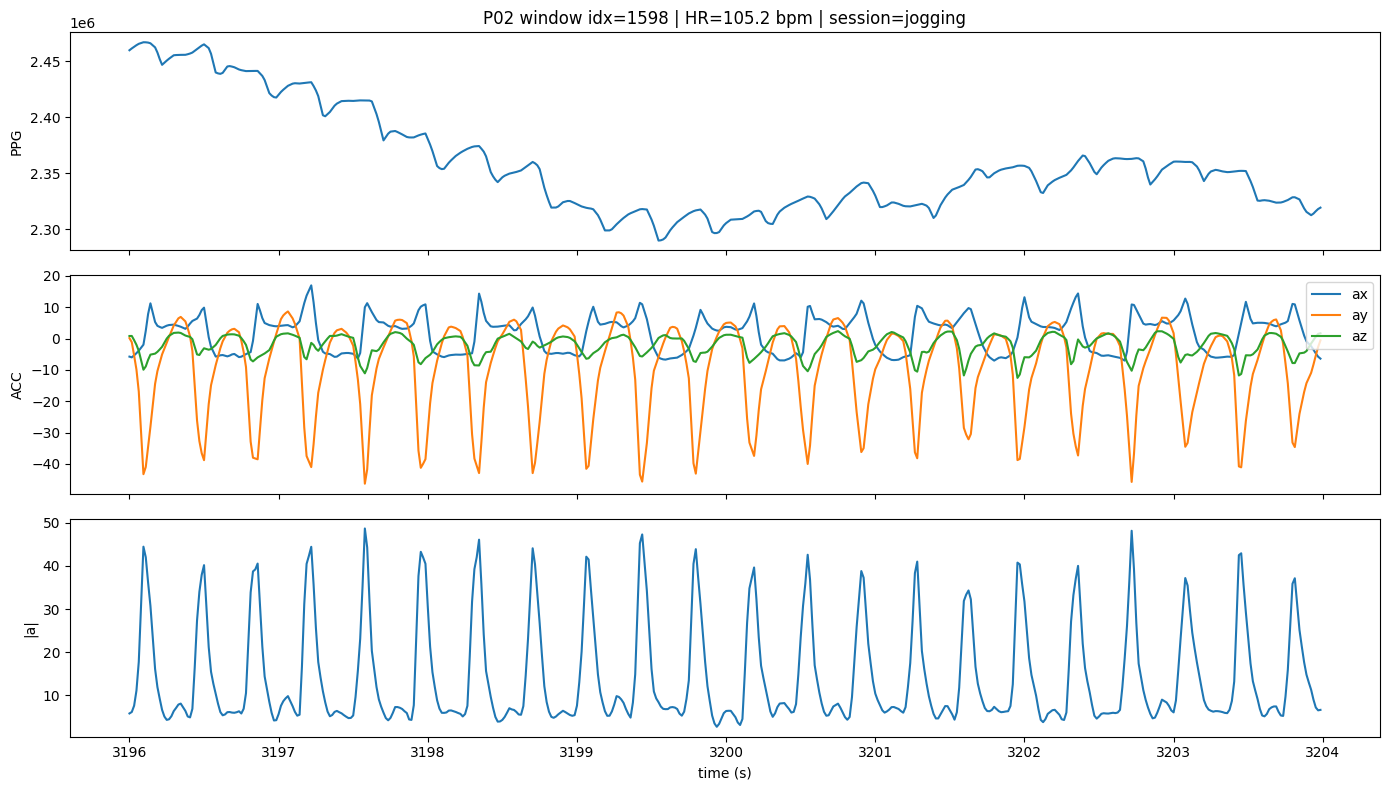

In [7]:
# A labeled window from the manifest
w_sub = windows[windows["subject_id"].astype(str) == SUBJECT_ID].reset_index(drop=True)
assert len(w_sub) > 0, f"No windows for {SUBJECT_ID}"
row = w_sub.sample(1, random_state=0).iloc[0]
wi0, wi1 = int(row["start_idx"]), int(row["end_idx"])
hr_label = float(row["hr"]) if "hr" in row and row["hr"] == row["hr"] else float("nan")
session = row.get("session", "n/a")

tw = np.arange(wi0, wi1) / fs
ppg_w = ppg[0, wi0:wi1]
acc_w = acc[:, wi0:wi1]

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(14, 8))
ax[0].plot(tw, ppg_w)
ax[0].set_title(
    f"{SUBJECT_ID} window idx={int(row['window_idx'])} | HR={hr_label:.1f} bpm | session={session}"
)
ax[0].set_ylabel("PPG")
for j, lbl in enumerate(["ax", "ay", "az"]):
    ax[1].plot(tw, acc_w[j], label=lbl)
ax[1].set_ylabel("ACC")
ax[1].legend(loc="upper right")
ax[2].plot(tw, np.linalg.norm(acc_w, axis=0))
ax[2].set_ylabel("|a|")
ax[2].set_xlabel("time (s)")
plt.tight_layout()
plt.show()

## Filtering & spectral analysis

Compare a classic SciPy bandpass against the repo's `BandpassButter`
operator. They should match almost exactly — the point is to confirm
training-parity rather than discover differences.


In [8]:
# ── Shared helpers ───────────────────────────────────────────────────────────

low_hz, high_hz = 0.7, 5.0  # conservative HR-focused band


def bandpass_scipy(x, fs, lo=low_hz, hi=high_hz, order=4):
    nyq = 0.5 * fs
    sos = signal.butter(order, [lo / nyq, hi / nyq], btype="bandpass", output="sos")
    return signal.sosfiltfilt(sos, x).astype(np.float32)


def bandpass_repo(x, fs, lo=low_hz, hi=high_hz, order=4, mod="ppg"):
    """Wraps the repo BandpassButter on a 1-D signal."""
    s = Sample(signals={mod: x.astype(np.float32)[None, :]}, targets={}, meta={"fs": float(fs)})
    tf = BandpassButter(low_hz=lo, high_hz=hi, order=order, default_fs=fs, modalities=[mod])
    return np.asarray(tf(s).signals[mod][0], dtype=np.float32)


def welch_psd(x, fs, nperseg=256):
    return signal.welch(x, fs=fs, nperseg=min(nperseg, len(x)))

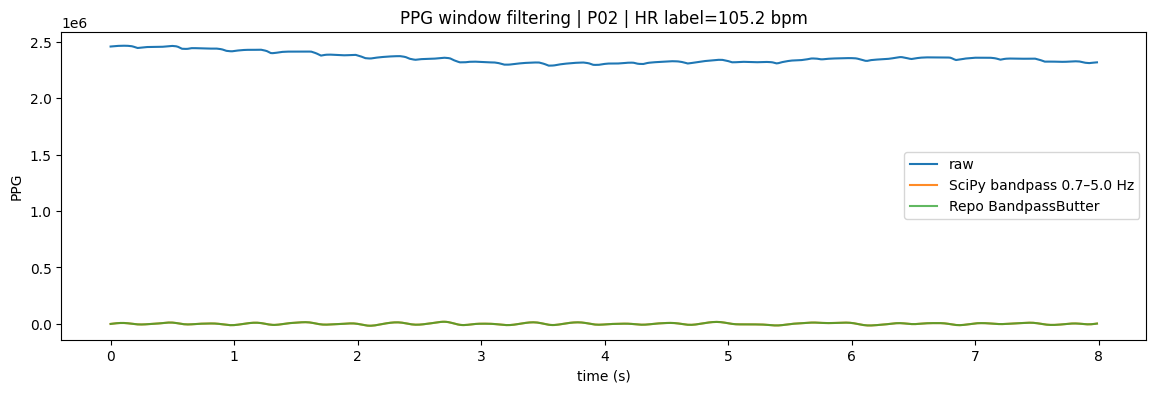

Repo vs SciPy — corrcoef: 1.000000  max|diff|: 0.00e+00  rmse: 0.00e+00


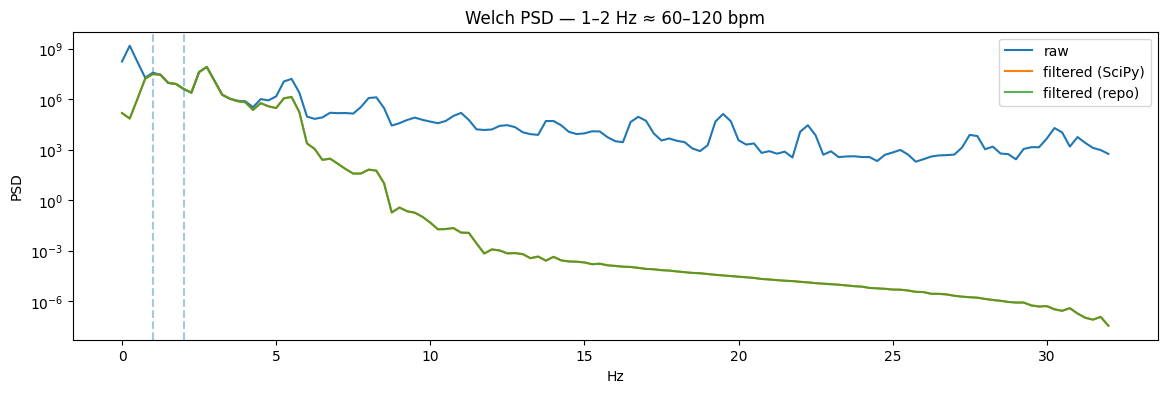

In [9]:
if not HAS_SCIPY:
    print("SciPy unavailable — skipping filter demo.")
else:
    x = ppg_w.astype(np.float32)
    x_sci = bandpass_scipy(x, fs)
    x_repo = None
    if Sample and BandpassButter:
        try:
            x_repo = bandpass_repo(x, fs)
        except Exception as e:
            print(f"Repo filter failed: {e!r}")

    tw = np.arange(len(x)) / fs
    plt.figure(figsize=(14, 4))
    plt.plot(tw, x, label="raw")
    plt.plot(tw, x_sci, label=f"SciPy bandpass {low_hz}–{high_hz} Hz", alpha=0.9)
    if x_repo is not None:
        plt.plot(tw, x_repo, label="Repo BandpassButter", alpha=0.75)
    plt.title(f"PPG window filtering | {SUBJECT_ID} | HR label={hr_label:.1f} bpm")
    plt.xlabel("time (s)")
    plt.ylabel("PPG")
    plt.legend()
    plt.show()

    if x_repo is not None:
        diff = x_repo - x_sci
        print(
            f"Repo vs SciPy — corrcoef: {np.corrcoef(x_repo, x_sci)[0,1]:.6f}  "
            f"max|diff|: {np.max(np.abs(diff)):.2e}  rmse: {np.sqrt(np.mean(diff**2)):.2e}"
        )

    # PSD comparison
    f_raw, P_raw = welch_psd(x, fs)
    f_sci, P_sci = welch_psd(x_sci, fs)

    plt.figure(figsize=(14, 4))
    plt.semilogy(f_raw, P_raw, label="raw")
    plt.semilogy(f_sci, P_sci, label="filtered (SciPy)")
    if x_repo is not None:
        plt.semilogy(*welch_psd(x_repo, fs), label="filtered (repo)", alpha=0.8)
    plt.axvline(1.0, ls="--", alpha=0.4)
    plt.axvline(2.0, ls="--", alpha=0.4)
    plt.title("Welch PSD — 1–2 Hz ≈ 60–120 bpm")
    plt.xlabel("Hz")
    plt.ylabel("PSD")
    plt.legend()
    plt.show()

## Toy HR estimation

Peak-detection and autocorrelation baselines on filtered PPG. Neither is
production-grade, but they set a signal-processing floor and sanity-check
the labels.


Label HR: 105.24 bpm
Peak-based: 160.00 bpm | Autocorr: 54.86 bpm


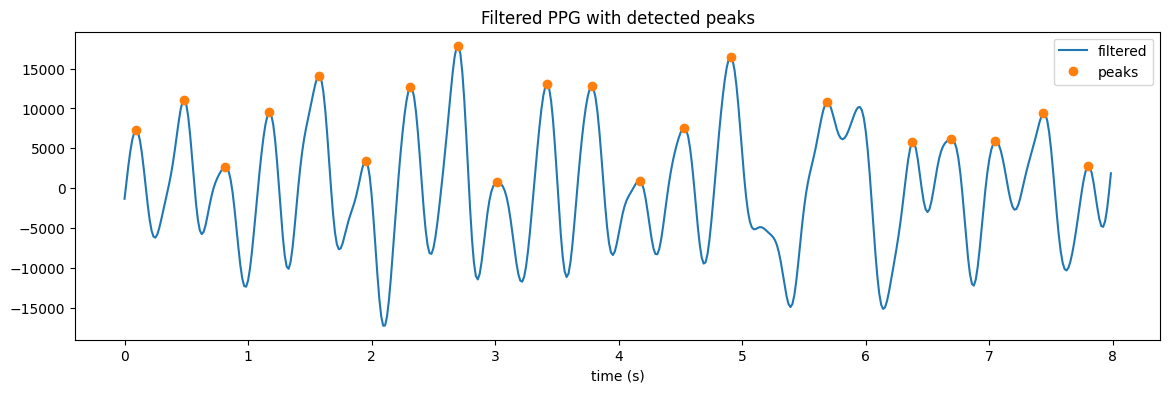

In [10]:
def estimate_hr_peaks(ppg_f, fs, hr_min=40.0, hr_max=200.0):
    dist = max(int(fs * 60 / hr_max), 1)
    prom = 0.3 * float(np.std(ppg_f) + 1e-8)
    peaks, _ = signal.find_peaks(ppg_f, distance=dist, prominence=prom)
    if len(peaks) < 2:
        return float("nan")
    ibi = np.diff(peaks) / fs
    hr = 60.0 / float(np.median(ibi))
    return hr if hr_min <= hr <= hr_max else float("nan")


def estimate_hr_autocorr(ppg_f, fs, hr_min=40.0, hr_max=200.0):
    x = ppg_f.astype(np.float64) - np.mean(ppg_f)
    if len(x) < 4:
        return float("nan")
    ac = np.correlate(x, x, mode="full")[len(x) - 1 :]
    ac[0] = 0.0
    lag_min, lag_max = int(fs * 60 / hr_max), min(int(fs * 60 / hr_min), len(ac) - 1)
    if lag_max <= lag_min + 1:
        return float("nan")
    lag = lag_min + int(np.argmax(ac[lag_min:lag_max]))
    hr = 60.0 * fs / lag
    return hr if hr_min <= hr <= hr_max else float("nan")


if HAS_SCIPY:
    x_f = bandpass_scipy(ppg_w.astype(np.float32), fs)
    hr_pk = estimate_hr_peaks(x_f, fs)
    hr_ac = estimate_hr_autocorr(x_f, fs)

    print(f"Label HR: {hr_label:.2f} bpm")
    print(f"Peak-based: {hr_pk:.2f} bpm | Autocorr: {hr_ac:.2f} bpm")

    # Visualize peaks
    prom = 0.3 * float(np.std(x_f) + 1e-8)
    peaks, _ = signal.find_peaks(x_f, distance=max(int(fs * 60 / 200), 1), prominence=prom)
    tw = np.arange(len(x_f)) / fs
    plt.figure(figsize=(14, 4))
    plt.plot(tw, x_f, label="filtered")
    plt.plot(tw[peaks], x_f[peaks], "o", label="peaks")
    plt.title("Filtered PPG with detected peaks")
    plt.xlabel("time (s)")
    plt.legend()
    plt.show()

## Toy HR baseline on val split

Run the peak-based estimator across a random sample of validation windows
and compare against the Polar-derived labels.


Evaluated: 300/300 windows
SciPy baseline — MAE: 8.70 bpm | RMSE: 14.85 bpm


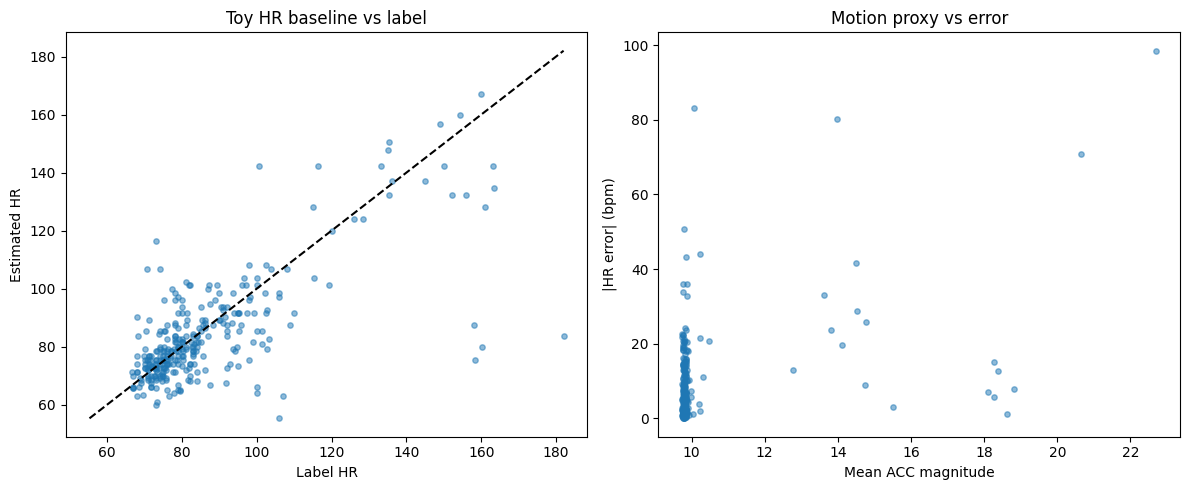

In [11]:
if WindowedNpzDataset is None or not HAS_SCIPY:
    print("Skipping — needs biosignals + SciPy.")
else:
    ds_val = WindowedNpzDataset(
        root=str(GALAXY_ROOT),
        split="val",
        view="views/windows.parquet",
        subjects_dir="subjects",
        modalities=("ppg", "acc"),
        label_col="hr",
        dropna_labels=True,
        subject_cache_size=8,
    )

    rng = np.random.default_rng(0)
    n = min(300, len(ds_val))
    idxs = rng.choice(len(ds_val), size=n, replace=False)

    use_repo = Sample is not None and BandpassButter is not None
    rows = []
    for idx in idxs:
        s = ds_val[int(idx)]
        ppg_x = s.signals["ppg"][0]
        fs_s = float(s.meta.get("fs", fs))
        y = float(s.targets.get("y", float("nan")))
        if not np.isfinite(y):
            continue
        try:
            xf = bandpass_scipy(ppg_x.astype(np.float32), fs_s)
            yhat = estimate_hr_peaks(xf, fs_s)
        except Exception:
            yhat = float("nan")
        acc_mag = float(np.mean(np.linalg.norm(s.signals["acc"], axis=0)))
        rows.append({"y": y, "yhat": yhat, "acc_mag_mean": acc_mag})

    df = pd.DataFrame(rows).dropna(subset=["y"])
    df = df[np.isfinite(df["yhat"])].reset_index(drop=True)

    err = df["yhat"] - df["y"]
    print(f"Evaluated: {len(df)}/{n} windows")
    print(
        f"SciPy baseline — MAE: {np.mean(np.abs(err)):.2f} bpm | RMSE: {np.sqrt(np.mean(err**2)):.2f} bpm"
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].scatter(df["y"], df["yhat"], alpha=0.5, s=15)
    lo, hi = min(df["y"].min(), df["yhat"].min()), max(df["y"].max(), df["yhat"].max())
    axes[0].plot([lo, hi], [lo, hi], "k--")
    axes[0].set_xlabel("Label HR")
    axes[0].set_ylabel("Estimated HR")
    axes[0].set_title("Toy HR baseline vs label")

    axes[1].scatter(df["acc_mag_mean"], np.abs(err), alpha=0.5, s=15)
    axes[1].set_xlabel("Mean ACC magnitude")
    axes[1].set_ylabel("|HR error| (bpm)")
    axes[1].set_title("Motion proxy vs error")
    plt.tight_layout()
    plt.show()

## Training-parity transforms (YAML config)

Load the same transform pipeline that training uses, apply it to a raw
window, and compare. Also demonstrates building custom operator chains
with the repo's composable transform building blocks.


Before: ['ppg', 'acc'] | After: ['ppg', 'acc']
PPG mean/std before: 2128607.5000 / 104408.8984
PPG mean/std after : 0.0000 / 1.0000


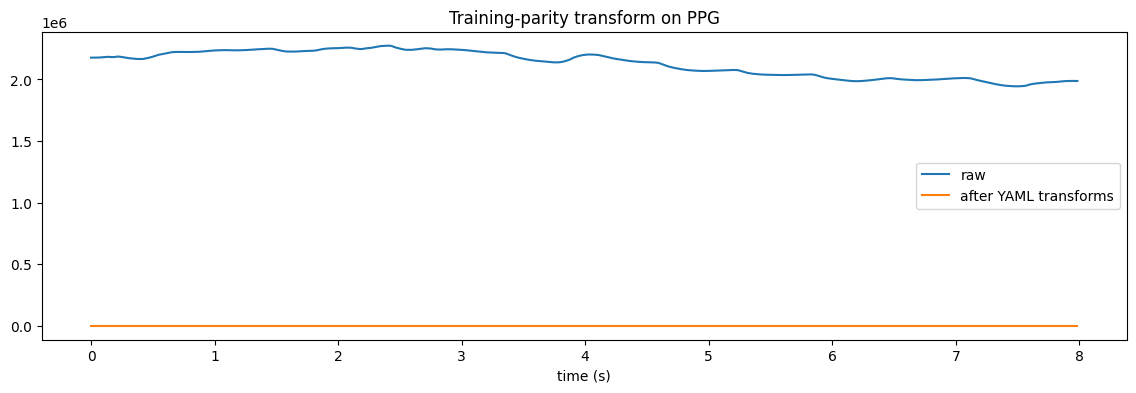

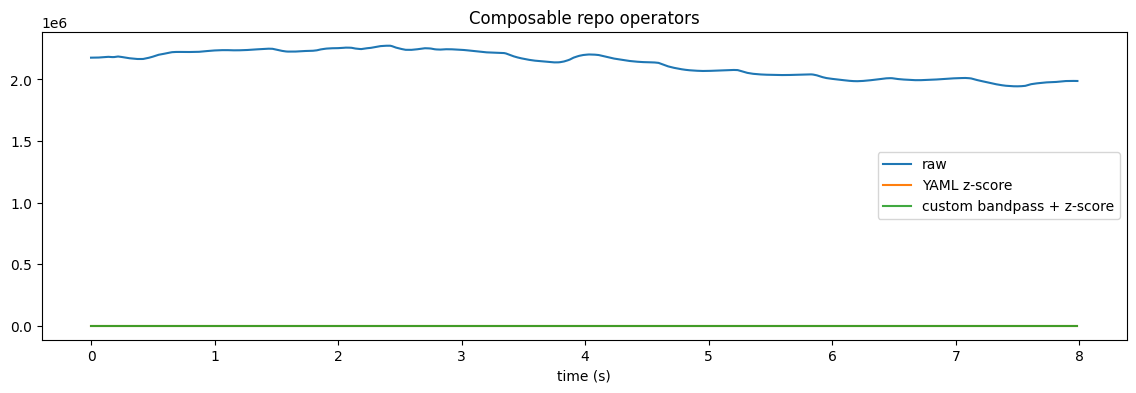


Resample demo — ACC before: (3, 256) | after: (3, 512)


In [12]:
if OmegaConf is None or build_transform is None or WindowedNpzDataset is None:
    print("Repo transforms not importable — skipping.")
else:
    tf_cfg_path = REPO_ROOT / "configs/transforms/galaxyppg/hr_fusion.yaml"
    assert tf_cfg_path.exists(), f"Missing config: {tf_cfg_path}"

    tf_cfg = OmegaConf.load(tf_cfg_path)
    tf_yaml = build_transform(tf_cfg["val"])

    # Reuse ds_val from earlier (or rebuild)
    try:
        ds_val
    except NameError:
        ds_val = WindowedNpzDataset(
            root=str(GALAXY_ROOT),
            split="val",
            view="views/windows.parquet",
            subjects_dir="subjects",
            modalities=("ppg", "acc"),
            label_col="hr",
            dropna_labels=True,
            subject_cache_size=8,
        )

    s0 = ds_val[0]
    s1 = tf_yaml(s0)

    print(f"Before: {list(s0.signals.keys())} | After: {list(s1.signals.keys())}")
    p0, p1 = s0.signals["ppg"], s1.signals["ppg"]
    print(f"PPG mean/std before: {np.mean(p0):.4f} / {np.std(p0):.4f}")
    print(f"PPG mean/std after : {np.mean(p1):.4f} / {np.std(p1):.4f}")

    fs0 = float(s0.meta.get("fs", 1.0))
    t = np.arange(p0.shape[-1]) / fs0
    plt.figure(figsize=(14, 4))
    plt.plot(t, p0[0], label="raw")
    plt.plot(t, p1[0], label="after YAML transforms")
    plt.title("Training-parity transform on PPG")
    plt.xlabel("time (s)")
    plt.legend()
    plt.show()

    # Custom operator composition (bandpass + z-score)
    if Compose and EnsureFloat32 and BandpassButter and ZScorePerChannel and HAS_SCIPY:
        tf_custom = Compose(
            [
                EnsureFloat32(),
                BandpassButter(
                    low_hz=low_hz, high_hz=high_hz, order=4, default_fs=fs0, modalities=["ppg"]
                ),
                ZScorePerChannel(modalities=["ppg"]),
            ]
        )
        s2 = tf_custom(s0)
        plt.figure(figsize=(14, 4))
        plt.plot(t, p0[0], label="raw")
        plt.plot(t, p1[0], label="YAML z-score")
        plt.plot(t, s2.signals["ppg"][0], label="custom bandpass + z-score", alpha=0.9)
        plt.title("Composable repo operators")
        plt.xlabel("time (s)")
        plt.legend()
        plt.show()

    # Multimodal alignment demo (synthetic mismatch)
    if ResampleToPrimary and HAS_SCIPY:
        ppg_orig = np.asarray(s0.signals["ppg"], dtype=np.float32)
        acc_down = np.asarray(s0.signals["acc"], dtype=np.float32)[:, ::2]
        meta_mis = {**s0.meta, "fs_ppg": fs0, "fs_acc": fs0 / 2, "fs": fs0}
        s_mis = Sample(
            signals={"ppg": ppg_orig, "acc": acc_down}, targets=s0.targets, meta=meta_mis
        )
        rt = ResampleToPrimary(primary_modality="ppg", match_length="primary", update_meta=True)
        s_al = rt(s_mis)
        print(
            f"\nResample demo — ACC before: {acc_down.shape} | after: {s_al.signals['acc'].shape}"
        )

---
# QC metrics & quality gating

Per-window quality features: missingness, flatline detection, clipping,
motion (jerk RMS), and a PSD-based SNR proxy. These drive automatic
quality gating to trade coverage for accuracy.


In [13]:
# ── QC feature extraction ────────────────────────────────────────────────────

assert HAS_SCIPY and WindowedNpzDataset, "Need SciPy + biosignals for QC."


def _welch(x, fs, nperseg=256):
    x = np.asarray(x, dtype=np.float64) - np.mean(x)
    nper = min(nperseg, len(x))
    if nper < 16:
        return np.array([]), np.array([])
    return signal.welch(x, fs=float(fs), nperseg=nper)


def qc_from_sample(s):
    """Compute QC features from a single WindowedNpzDataset Sample."""
    fs = float(s.meta.get("fs", 0.0))
    ppg = np.asarray(s.signals["ppg"][0], dtype=np.float32)
    acc = np.asarray(s.signals["acc"], dtype=np.float32)

    out = {
        "id": str(s.meta.get("id", "")),
        "subject_id": str(s.meta.get("subject_id", "")),
        "session": str(s.meta.get("session", "none")),
        "fs": fs,
        "hr_label": float(s.targets.get("y", float("nan"))),
    }

    # Missingness
    out["ppg_missing_frac"] = 1.0 - float(np.mean(np.isfinite(ppg)))
    out["acc_missing_frac"] = 1.0 - float(np.mean(np.isfinite(acc)))

    # Flatline / signal energy
    sd = float(np.std(ppg))
    out["ppg_std"] = sd
    out["ppg_ptp"] = float(np.ptp(ppg))
    d = np.diff(ppg)
    out["ppg_zcr"] = float(np.mean((d[:-1] >= 0) != (d[1:] >= 0))) if len(d) >= 2 else float("nan")

    # Clipping proxy
    eps = max(1e-6, 1e-3 * (sd + 1e-12))
    out["ppg_clip_total_frac"] = float(
        np.mean(ppg <= np.min(ppg) + eps) + np.mean(ppg >= np.max(ppg) - eps)
    )

    # Motion
    mag = np.linalg.norm(acc, axis=0)
    jerk = np.diff(mag) * fs
    out["acc_mag_mean"] = float(np.mean(mag))
    out["acc_jerk_rms"] = float(np.sqrt(np.mean(jerk**2))) if len(jerk) else float("nan")
    out["acc_jerk_p95"] = float(np.percentile(np.abs(jerk), 95)) if len(jerk) else float("nan")

    # SNR proxy (HR-band power vs rest)
    f, P = _welch(ppg, fs)
    if len(f):
        band = (f >= 0.7) & (f <= 5.0)
        fb, Pb = f[band], P[band]
        if fb.size:
            k = int(np.argmax(Pb))
            f0 = float(fb[k])
            peak = (fb >= f0 - 0.2) & (fb <= f0 + 0.2)
            P_peak = float(np.mean(Pb[peak])) if peak.any() else 0
            P_noise = float(np.median(Pb[~peak])) if (~peak).any() else 1e-12
            ratio = (P_peak + 1e-12) / (P_noise + 1e-12)
            out["ppg_f0_hz"] = f0
            out["ppg_snr_db"] = 10.0 * np.log10(ratio)
        else:
            out["ppg_f0_hz"] = out["ppg_snr_db"] = float("nan")
    else:
        out["ppg_f0_hz"] = out["ppg_snr_db"] = float("nan")

    return out

In [14]:
# ── Compute QC on val subset ─────────────────────────────────────────────────

# Single dataset instance used for all remaining analysis
try:
    ds_val
except NameError:
    ds_val = WindowedNpzDataset(
        root=str(GALAXY_ROOT),
        split="val",
        view="views/windows.parquet",
        subjects_dir="subjects",
        modalities=("ppg", "acc"),
        label_col="hr",
        dropna_labels=True,
        subject_cache_size=8,
    )

rng = np.random.default_rng(0)
N_QC = 1500
idxs_qc = rng.choice(len(ds_val), size=min(N_QC, len(ds_val)), replace=False)
print(f"QC subset: {len(idxs_qc)} windows from val (n={len(ds_val)})")

qc_rows = []
for idx in idxs_qc:
    r = qc_from_sample(ds_val[int(idx)])
    r["ds_idx"] = int(idx)
    qc_rows.append(r)

qc_df = pd.DataFrame(qc_rows)
print(f"qc_df: {qc_df.shape}")
print("Missingness (should be ~0):")
print(qc_df[["ppg_missing_frac", "acc_missing_frac"]].describe())

QC subset: 1500 windows from val (n=4723)
qc_df: (1500, 17)
Missingness (should be ~0):
       ppg_missing_frac  acc_missing_frac
count            1500.0            1500.0
mean                0.0               0.0
std                 0.0               0.0
min                 0.0               0.0
25%                 0.0               0.0
50%                 0.0               0.0
75%                 0.0               0.0
max                 0.0               0.0


Flag rates:
flag_any            0.100667
flag_high_motion    0.100000
flag_flat           0.000667
flag_low_snr        0.000000
flag_clip           0.000000
dtype: float64


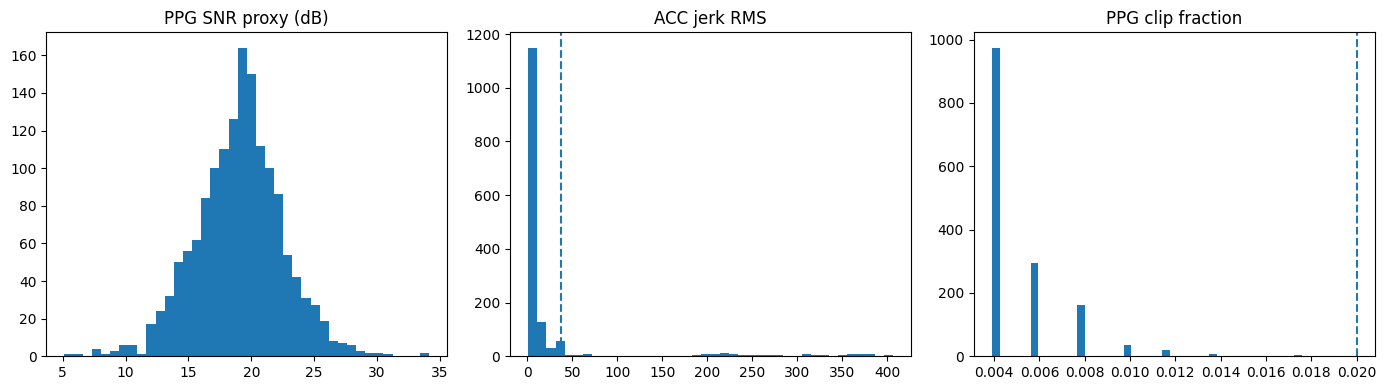

In [15]:
# ── QC flag rates & distributions ────────────────────────────────────────────

ppg_global_std = float(stats["ppg"]["std"][0]) if "std" in stats.get("ppg", {}) else None
flat_thresh = 0.01 * ppg_global_std if ppg_global_std else 1e-3
clip_thresh = 0.02
snr_thresh = 0.0
jerk_p90 = float(np.nanpercentile(qc_df["acc_jerk_rms"], 90))

qc_df["flag_flat"] = qc_df["ppg_std"] < flat_thresh
qc_df["flag_clip"] = qc_df["ppg_clip_total_frac"] > clip_thresh
qc_df["flag_low_snr"] = qc_df["ppg_snr_db"] < snr_thresh
qc_df["flag_high_motion"] = qc_df["acc_jerk_rms"] > jerk_p90
qc_df["flag_any"] = qc_df[["flag_flat", "flag_clip", "flag_low_snr", "flag_high_motion"]].any(
    axis=1
)

print("Flag rates:")
print(
    qc_df[["flag_flat", "flag_clip", "flag_low_snr", "flag_high_motion", "flag_any"]]
    .mean()
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(qc_df["ppg_snr_db"].dropna(), bins=40)
ax[0].set_title("PPG SNR proxy (dB)")
ax[1].hist(qc_df["acc_jerk_rms"].dropna(), bins=40)
ax[1].set_title("ACC jerk RMS")
ax[1].axvline(jerk_p90, ls="--")
ax[2].hist(qc_df["ppg_clip_total_frac"].dropna(), bins=40)
ax[2].set_title("PPG clip fraction")
ax[2].axvline(clip_thresh, ls="--")
plt.tight_layout()
plt.show()

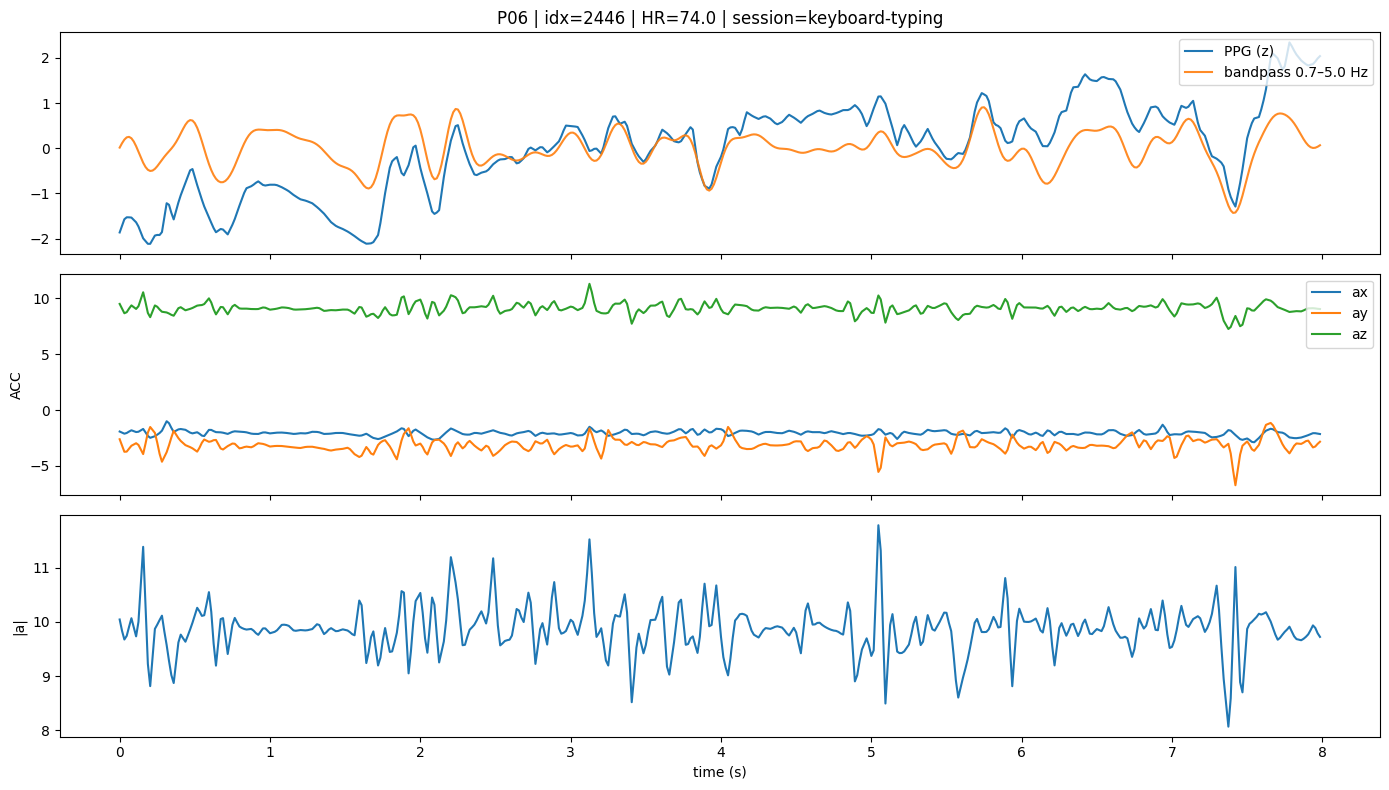

In [16]:
# Quick viewer for a flagged window
def plot_window_by_idx(ds, idx, band=(0.7, 5.0), order=4):
    s = ds[int(idx)]
    fs_s = float(s.meta.get("fs", 1.0))
    ppg_x = np.asarray(s.signals["ppg"][0], dtype=np.float32)
    acc_x = np.asarray(s.signals["acc"], dtype=np.float32)
    y = float(s.targets.get("y", float("nan")))

    p = (ppg_x - np.mean(ppg_x)) / (np.std(ppg_x) + 1e-6)
    sos = signal.butter(
        order, [band[0] / (0.5 * fs_s), band[1] / (0.5 * fs_s)], btype="bandpass", output="sos"
    )
    pf = signal.sosfiltfilt(sos, p).astype(np.float32)

    t = np.arange(ppg_x.size) / fs_s
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(14, 8))
    ax[0].plot(t, p, label="PPG (z)")
    ax[0].plot(t, pf, label=f"bandpass {band[0]}–{band[1]} Hz", alpha=0.9)
    ax[0].set_title(
        f"{s.meta.get('subject_id','')} | idx={idx} | HR={y:.1f} | session={s.meta.get('session','')}"
    )
    ax[0].legend(loc="upper right")
    for j, lbl in enumerate(["ax", "ay", "az"]):
        ax[1].plot(t, acc_x[j], label=lbl)
    ax[1].set_ylabel("ACC")
    ax[1].legend(loc="upper right")
    ax[2].plot(t, np.linalg.norm(acc_x, axis=0))
    ax[2].set_ylabel("|a|")
    ax[2].set_xlabel("time (s)")
    plt.tight_layout()
    plt.show()


# Lowest-SNR window
bad_idx = int(qc_df.sort_values("ppg_snr_db").iloc[0]["ds_idx"])
plot_window_by_idx(ds_val, bad_idx)

## Session-stratified QC

Different experimental conditions (rest, TSST stress, exercise) produce
different motion levels and signal quality.


,count,mean,median,std
session,,,,
adaptation,3440,79.499112,78.000000,9.591342
meditation-1,3370,77.437459,76.000000,8.684929
meditation-2,3368,77.405303,76.248332,8.701353
tsst-speech,2006,89.106332,88.000000,10.858778
screen-reading,2002,79.947579,79.000000,9.634022
mobile-typing,1988,77.563492,77.000000,6.848206
standing,1987,89.431340,89.007715,11.309444
keyboard-typing,1986,79.301440,80.000000,7.479601
baseline,1979,79.120520,77.000000,9.310926


,n,hr_mean,snr_mean,jerk_mean
session,,,,
meditation-2,147,75.880369,19.921402,1.682028
adaptation,139,76.975688,19.481550,1.385814
meditation-1,131,76.581754,19.176383,1.738755
tsst-prep,95,87.583943,20.323317,2.270213
keyboard-typing,88,76.377305,16.673689,19.589825
screen-reading,86,77.772298,20.452299,1.312035
rest-5,84,112.053494,17.941582,15.791272
baseline,82,77.543126,19.374253,1.102896
mobile-typing,79,74.483832,20.071751,4.207569


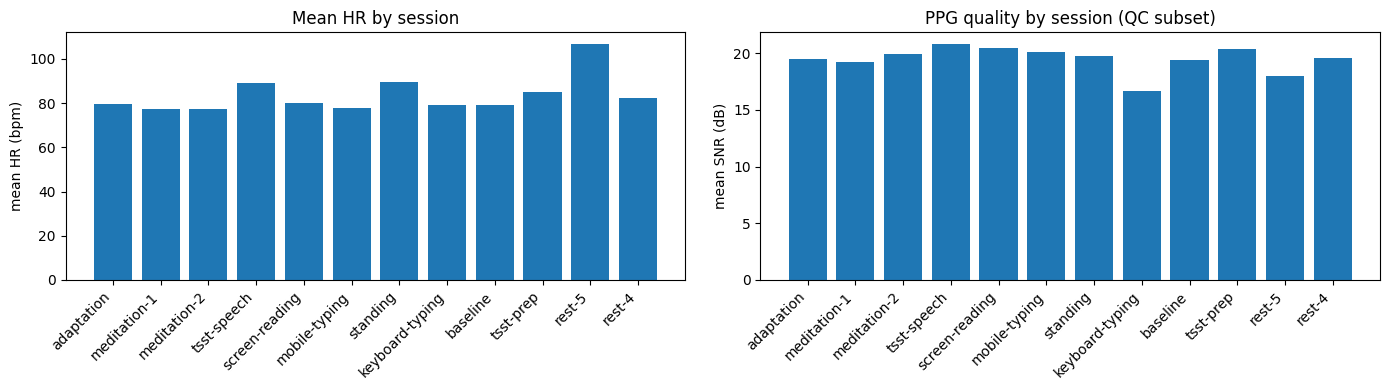

In [17]:
if "session" in windows.columns:
    hr_by_sess = (
        windows.groupby("session")["hr"]
        .agg(["count", "mean", "median", "std"])
        .sort_values("count", ascending=False)
    )
    display(hr_by_sess.head(15))

    qc_by_sess = (
        qc_df.groupby("session")
        .agg(
            n=("id", "count"),
            hr_mean=("hr_label", "mean"),
            snr_mean=("ppg_snr_db", "mean"),
            jerk_mean=("acc_jerk_rms", "mean"),
        )
        .sort_values("n", ascending=False)
    )
    display(qc_by_sess.head(15))

    top_sessions = hr_by_sess.head(12).index.tolist()
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].bar(range(len(top_sessions)), hr_by_sess.loc[top_sessions, "mean"])
    axes[0].set_xticks(range(len(top_sessions)))
    axes[0].set_xticklabels(top_sessions, rotation=45, ha="right")
    axes[0].set_ylabel("mean HR (bpm)")
    axes[0].set_title("Mean HR by session")
    if "snr_mean" in qc_by_sess.columns:
        vals = [
            qc_by_sess.loc[s, "snr_mean"] if s in qc_by_sess.index else float("nan")
            for s in top_sessions
        ]
        axes[1].bar(range(len(top_sessions)), vals)
        axes[1].set_xticks(range(len(top_sessions)))
        axes[1].set_xticklabels(top_sessions, rotation=45, ha="right")
        axes[1].set_ylabel("mean SNR (dB)")
        axes[1].set_title("PPG quality by session (QC subset)")
    plt.tight_layout()
    plt.show()

## Stress labels (TSST / SSST)

Subject-level aggregation avoids the confound of unequal window counts
per subject.


/tmp/ipykernel_1917777/3074284637.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(k) for k in sorted(d[label_col].unique())])


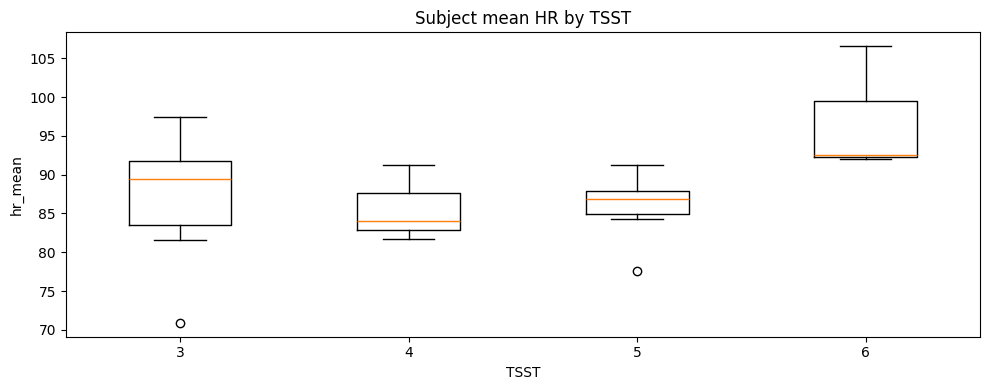

/tmp/ipykernel_1917777/3074284637.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(k) for k in sorted(d[label_col].unique())])


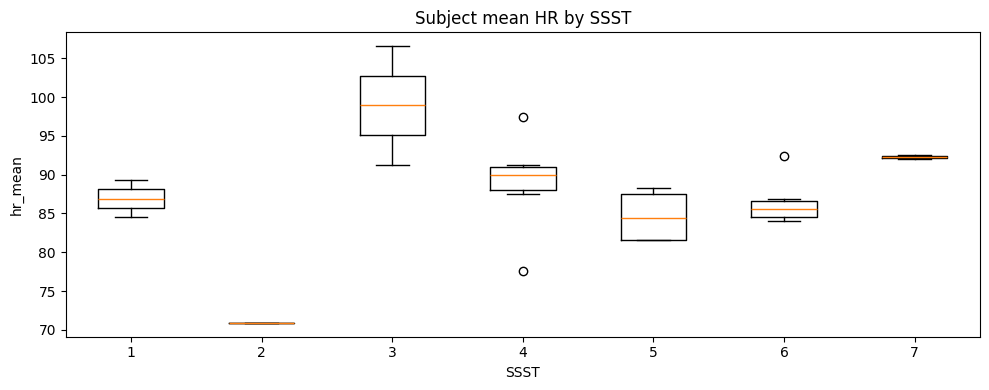

In [18]:
if {"tsst", "ssst"}.issubset(subjects.columns):
    subj_hr = windows.groupby("subject_id")["hr"].mean().rename("hr_mean").reset_index()
    subj_df = subjects.merge(subj_hr, on="subject_id", how="left")

    def boxplot_by_label(df, label_col, val_col, title):
        d = df.dropna(subset=[label_col, val_col]).copy()
        d[label_col] = d[label_col].astype(int)
        groups = [
            d.loc[d[label_col] == k, val_col].astype(float).to_numpy()
            for k in sorted(d[label_col].unique())
        ]
        plt.figure(figsize=(10, 4))
        plt.boxplot(groups, labels=[str(k) for k in sorted(d[label_col].unique())])
        plt.xlabel(label_col.upper())
        plt.ylabel(val_col)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    boxplot_by_label(subj_df, "tsst", "hr_mean", "Subject mean HR by TSST")
    boxplot_by_label(subj_df, "ssst", "hr_mean", "Subject mean HR by SSST")

---
# Adaptive HR baseline & coverage–error tradeoff

A slightly more sophisticated signal-processing baseline:
1. PSD → dominant frequency in [0.7, 4] Hz
2. Adaptive bandpass around that peak
3. Robust peak detection with IBI outlier trimming
4. Optional motion gating via ACC jerk RMS

Then we sweep QC strictness to trace out the coverage–error curve.


In [19]:
# ── Adaptive baseline helpers ────────────────────────────────────────────────


def _zscore(x, eps=1e-6):
    x = x.astype(np.float32) - np.mean(x)
    return x / (np.std(x) + eps)


def _dominant_freq(x, fs, fmin=0.7, fmax=4.0):
    f, P = _welch(x, fs)
    if not len(f):
        return float("nan")
    band = (f >= fmin) & (f <= fmax)
    if not band.any():
        return float("nan")
    return float(f[band][np.argmax(P[band])])


def _acc_motion_feats(acc, fs):
    mag = np.linalg.norm(acc, axis=0)
    jerk = np.diff(mag) * fs
    return {
        "acc_mag_mean": float(np.mean(mag)),
        "acc_jerk_rms": float(np.sqrt(np.mean(jerk**2))) if len(jerk) else float("nan"),
    }


def _hr_from_peaks_robust(xf, fs, hr_min=40.0, hr_max=200.0):
    if len(xf) < 16:
        return float("nan"), {}
    dist = max(int(fs * 60 / hr_max), 1)
    mad = float(np.median(np.abs(xf - np.median(xf))))
    prom = 0.8 * 1.4826 * (mad + 1e-6)

    peaks, props = signal.find_peaks(xf, distance=dist, prominence=prom)
    if len(peaks) < 2:
        return float("nan"), {"n_peaks": len(peaks)}

    ibi = np.diff(peaks) / fs
    ibi = ibi[(ibi >= 60 / hr_max) & (ibi <= 60 / hr_min)]
    if not len(ibi):
        return float("nan"), {"n_peaks": len(peaks)}

    med = float(np.median(ibi))
    ibi2 = ibi[(ibi >= 0.5 * med) & (ibi <= 1.5 * med)]
    if not len(ibi2):
        ibi2 = ibi

    hr = 60.0 / float(np.median(ibi2))
    cv = float(np.std(ibi2) / (np.mean(ibi2) + 1e-12))
    return hr, {"n_peaks": len(peaks), "ibi_cv": cv}


def estimate_hr_adaptive(ppg_1d, acc_ct, fs, *, motion_th=None):
    motion = _acc_motion_feats(acc_ct, fs)
    if motion_th and np.isfinite(motion["acc_jerk_rms"]) and motion["acc_jerk_rms"] > motion_th:
        return float("nan"), {"gated": True, **motion}

    xz = _zscore(ppg_1d)
    f0 = _dominant_freq(xz, fs)
    lo = max(0.5, f0 - 0.6) if np.isfinite(f0) else 0.7
    hi = min(8.0, f0 + 0.8) if np.isfinite(f0) else 5.0
    nyq = 0.5 * fs
    sos = signal.butter(4, [lo / nyq, hi / nyq], btype="bandpass", output="sos")
    xf = signal.sosfiltfilt(sos, xz).astype(np.float32)

    # Try both polarities
    hr1, i1 = _hr_from_peaks_robust(xf, fs)
    hr2, i2 = _hr_from_peaks_robust(-xf, fs)
    score = (
        lambda h, i: (i.get("n_peaks", 0) * 10 - i.get("ibi_cv", 1) * 50)
        if np.isfinite(h)
        else -1e9
    )
    hr, info = (hr2, i2) if score(hr2, i2) > score(hr1, i1) else (hr1, i1)

    return hr, {"f0_hz": f0, "band": (lo, hi), **motion, **info}

     no_gate | coverage=0.999 | MAE=16.01 | RMSE=28.02 | n=1199
    gate_p70 | coverage=0.700 | MAE=7.96 | RMSE=14.46 | n=840
    gate_p90 | coverage=0.899 | MAE=11.71 | RMSE=20.52 | n=1079


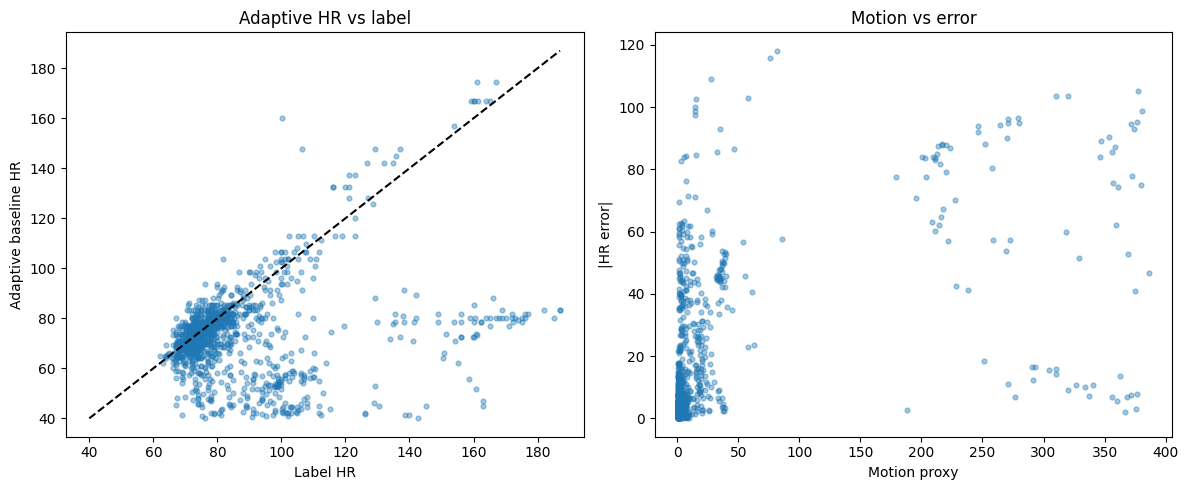

In [20]:
# ── Evaluate adaptive baseline with motion gating ────────────────────────────

N_EVAL = 1200
idxs_eval = rng.choice(len(ds_val), size=min(N_EVAL, len(ds_val)), replace=False)

# Compute motion thresholds
motion_vals = []
for idx in idxs_eval:
    s = ds_val[int(idx)]
    motion_vals.append(
        _acc_motion_feats(s.signals["acc"], float(s.meta.get("fs", 1)))["acc_jerk_rms"]
    )
th_70 = float(np.nanpercentile(motion_vals, 70))
th_90 = float(np.nanpercentile(motion_vals, 90))


def run_eval(motion_th=None):
    rows = []
    for idx in idxs_eval:
        s = ds_val[int(idx)]
        y = float(s.targets.get("y", float("nan")))
        if not np.isfinite(y):
            continue
        fs_s = float(s.meta.get("fs", 1))
        yhat, info = estimate_hr_adaptive(
            s.signals["ppg"][0], s.signals["acc"], fs_s, motion_th=motion_th
        )
        rows.append({"y": y, "yhat": yhat, **info})
    return pd.DataFrame(rows)


def summarize(df, name):
    ok = df[np.isfinite(df["yhat"])]
    cov = len(ok) / max(1, len(df))
    if not len(ok):
        print(f"{name:>12s} | coverage={cov:.3f} | no estimates")
        return
    err = ok["yhat"] - ok["y"]
    print(
        f"{name:>12s} | coverage={cov:.3f} | MAE={np.mean(np.abs(err)):.2f} | RMSE={np.sqrt(np.mean(err**2)):.2f} | n={len(ok)}"
    )


for label, th in [("no_gate", None), ("gate_p70", th_70), ("gate_p90", th_90)]:
    summarize(run_eval(th), label)

# Scatter (no gate)
df_all = run_eval()
ok = df_all[np.isfinite(df_all["yhat"])]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(ok["y"], ok["yhat"], alpha=0.4, s=12)
lo, hi = min(ok["y"].min(), ok["yhat"].min()), max(ok["y"].max(), ok["yhat"].max())
axes[0].plot([lo, hi], [lo, hi], "k--")
axes[0].set_xlabel("Label HR")
axes[0].set_ylabel("Adaptive baseline HR")
axes[0].set_title("Adaptive HR vs label")
axes[1].scatter(
    ok.get("acc_jerk_rms", ok.get("acc_mag_mean")), np.abs(ok["yhat"] - ok["y"]), alpha=0.4, s=12
)
axes[1].set_xlabel("Motion proxy")
axes[1].set_ylabel("|HR error|")
axes[1].set_title("Motion vs error")
plt.tight_layout()
plt.show()

## Coverage–error sweep

Build a composite QC score (rank-based, so robust across subjects) and
sweep the keep fraction. This traces out the coverage–MAE tradeoff that
any quality-gating strategy faces.


In [21]:
# Full eval with QC metrics
eval_rows = []
for idx in idxs_eval:
    s = ds_val[int(idx)]
    y = float(s.targets.get("y", float("nan")))
    if not np.isfinite(y):
        continue
    fs_s = float(s.meta.get("fs", 1))
    qc = {
        "ppg_missing": 1 - float(np.mean(np.isfinite(s.signals["ppg"]))),
        "ppg_std": float(np.std(s.signals["ppg"])),
        "ppg_flat_frac": float(
            np.mean(
                np.abs(np.diff(s.signals["ppg"][0]))
                < 1e-4 * float(np.std(s.signals["ppg"]) + 1e-12)
            )
        ),
    }
    # SNR
    f, P = _welch(s.signals["ppg"][0], fs_s)
    if len(f):
        band = (f >= 0.7) & (f <= 5.0)
        hr_pow = float(np.trapz(P[band], f[band])) if band.any() else 0
        tot_pow = (
            float(np.trapz(P[(f >= 0.2) & (f <= 8)], f[(f >= 0.2) & (f <= 8)]))
            if ((f >= 0.2) & (f <= 8)).any()
            else 0
        )
        qc["snr_ratio"] = hr_pow / max(tot_pow - hr_pow, 1e-12)
    else:
        qc["snr_ratio"] = float("nan")
    motion = _acc_motion_feats(s.signals["acc"], fs_s)
    qc["jerk_rms"] = motion["acc_jerk_rms"]
    yhat, _ = estimate_hr_adaptive(s.signals["ppg"][0], s.signals["acc"], fs_s)
    eval_rows.append({"idx": int(idx), "y": y, "yhat": yhat, "ok_est": np.isfinite(yhat), **qc})

    # Attach session metadata
    view_df = pd.DataFrame(ds_val.rows)
    if "session" in view_df.columns:
        eval_rows[-1]["session"] = str(view_df.iloc[int(idx)].get("session", ""))

eval_df = pd.DataFrame(eval_rows)

/tmp/ipykernel_1917777/4272136558.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hr_pow = float(np.trapz(P[band], f[band])) if band.any() else 0
/tmp/ipykernel_1917777/4272136558.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  tot_pow = float(np.trapz(P[(f>=0.2)&(f<=8)], f[(f>=0.2)&(f<=8)])) if ((f>=0.2)&(f<=8)).any() else 0


,keep,coverage,mae,n
0,1.00,0.999167,16.008700,1199
1,0.95,0.949167,15.889868,1139
2,0.90,0.899167,15.383641,1079
3,0.85,0.849167,15.416632,1019
4,0.80,0.800000,15.641286,960
5,0.75,0.750000,15.536571,900
6,0.70,0.700000,15.683325,840
7,0.65,0.650000,15.947390,780
8,0.60,0.600000,16.117391,720
9,0.55,0.550833,16.386867,661


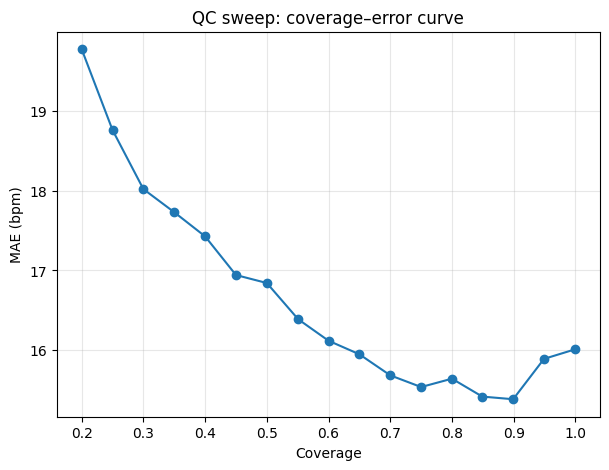

In [22]:
# Composite QC score (rank-based)
def _rank01(s):
    return s.rank(pct=True, method="average")


eval_df["qc_score"] = (
    0.45 * _rank01(eval_df["snr_ratio"].fillna(-np.inf))
    + 0.25 * _rank01(eval_df["ppg_std"].fillna(-np.inf))
    + 0.20 * _rank01(-eval_df["jerk_rms"].fillna(np.inf))
    + 0.10 * _rank01(-eval_df["ppg_flat_frac"].fillna(np.inf))
)

# Sweep
keep_fracs = np.linspace(1.0, 0.2, 17)
curve_rows = []
for kf in keep_fracs:
    thr = float(eval_df["qc_score"].quantile(1.0 - kf))
    allowed = eval_df["qc_score"] >= thr
    est = eval_df[allowed & eval_df["ok_est"] & np.isfinite(eval_df["yhat"])]
    cov = len(est) / max(1, len(eval_df))
    mae = float(np.mean(np.abs(est["yhat"] - est["y"]))) if len(est) else float("nan")
    curve_rows.append({"keep": kf, "coverage": cov, "mae": mae, "n": len(est)})

curve = pd.DataFrame(curve_rows)
display(curve)

plt.figure(figsize=(7, 5))
plt.plot(curve["coverage"], curve["mae"], "o-")
plt.xlabel("Coverage")
plt.ylabel("MAE (bpm)")
plt.title("QC sweep: coverage–error curve")
plt.grid(True, alpha=0.3)
plt.show()

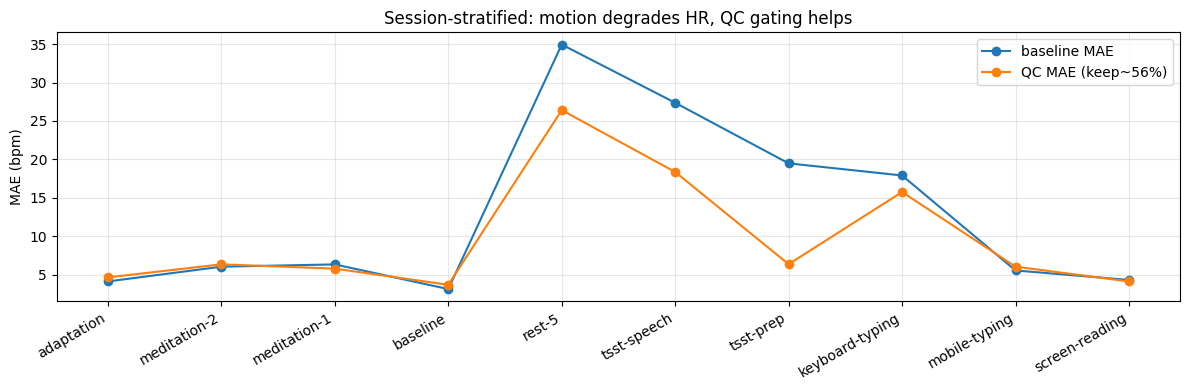

In [23]:
# Session-stratified view at a chosen operating point
TARGET_KEEP = 0.56
thr = float(eval_df["qc_score"].quantile(1 - TARGET_KEEP))
eval_df["qc_keep"] = eval_df["qc_score"] >= thr

if "session" in eval_df.columns:

    def _mae_masked(sub, mask):
        d = sub[mask & sub["ok_est"] & np.isfinite(sub["yhat"])]
        return float(np.mean(np.abs(d["yhat"] - d["y"]))) if len(d) else float("nan")

    sess_rows = []
    for sess, sub in eval_df.groupby("session"):
        sess_rows.append(
            {
                "session": sess,
                "n": len(sub),
                "baseline_mae": _mae_masked(sub, np.ones(len(sub), dtype=bool)),
                "qc_mae": _mae_masked(sub, sub["qc_keep"].to_numpy()),
            }
        )
    sess_df = pd.DataFrame(sess_rows).sort_values("n", ascending=False)

    topN = min(10, len(sess_df))
    plot_df = sess_df.head(topN)
    x = np.arange(len(plot_df))

    plt.figure(figsize=(12, 4))
    plt.plot(x, plot_df["baseline_mae"], "o-", label="baseline MAE")
    plt.plot(x, plot_df["qc_mae"], "o-", label=f"QC MAE (keep~{TARGET_KEEP:.0%})")
    plt.xticks(x, plot_df["session"], rotation=30, ha="right")
    plt.ylabel("MAE (bpm)")
    plt.title("Session-stratified: motion degrades HR, QC gating helps")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

---
# Feature embeddings & clustering

Lightweight spectral + motion features → PCA / UMAP → color by session
and label HR. Shows the data has structure even without a learned model,
and quantifies how much of that structure tracks cardiac rate vs session.


In [24]:
# ── Feature extraction ───────────────────────────────────────────────────────

try:
    from tqdm.auto import tqdm
except ImportError:

    def tqdm(x, **kw):
        return x


try:
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    SKLEARN_OK = True
except ImportError:
    SKLEARN_OK = False

try:
    import umap

    UMAP_OK = True
except ImportError:
    UMAP_OK = False

print(f"sklearn: {SKLEARN_OK} | umap: {UMAP_OK}")


def extract_features(ppg_1d, acc_3, fs):
    """Lightweight spectral + motion feature vector."""
    x = ppg_1d.astype(np.float32)
    xf = bandpass_scipy(x, fs) if HAS_SCIPY else x - np.mean(x)

    f, P = _welch(xf, fs) if HAS_SCIPY else (np.array([]), np.array([]))
    feats = {}

    if len(f):
        band = (f >= 0.7) & (f <= 5.0)
        feats["ppg_dom_hz"] = float(f[band][np.argmax(P[band])]) if band.any() else float("nan")
        for lo, hi, tag in [(0.7, 1.5, "0p7_1p5"), (1.5, 3.0, "1p5_3"), (3.0, 5.0, "3_5")]:
            m = (f >= lo) & (f <= hi)
            feats[f"ppg_bp_{tag}"] = float(np.trapz(P[m], f[m])) if m.any() else float("nan")
        # Spectral entropy
        Pb = P[band]
        s = Pb.sum()
        if s > 0:
            p = Pb / s
            feats["ppg_spec_entropy"] = -float(np.sum(p * np.log(p + 1e-12))) / np.log(
                len(p) + 1e-12
            )
        else:
            feats["ppg_spec_entropy"] = float("nan")
    else:
        feats.update(
            {
                k: float("nan")
                for k in [
                    "ppg_dom_hz",
                    "ppg_bp_0p7_1p5",
                    "ppg_bp_1p5_3",
                    "ppg_bp_3_5",
                    "ppg_spec_entropy",
                ]
            }
        )

    # ACC
    mag = np.linalg.norm(acc_3, axis=0)
    feats["acc_mag_mean"] = float(np.mean(mag))
    jerk = np.diff(mag) * fs
    feats["acc_jerk_rms"] = float(np.sqrt(np.mean(jerk**2))) if len(jerk) else float("nan")
    fA, PA = _welch(mag - np.mean(mag), fs) if HAS_SCIPY else (np.array([]), np.array([]))
    m = (fA >= 0.5) & (fA <= 3.0) if len(fA) else np.array([], dtype=bool)
    feats["acc_bp_0p5_3"] = float(np.trapz(PA[m], fA[m])) if m.any() else float("nan")

    return feats

sklearn: True | umap: False


In [25]:
N_EMBED = 2500
idxs_emb = rng.choice(len(ds_val), size=min(N_EMBED, len(ds_val)), replace=False)

feat_rows = []
for idx in tqdm(idxs_emb, desc="Features"):
    s = ds_val[int(idx)]
    fs_s = float(s.meta.get("fs", 1))
    if fs_s <= 0:
        continue
    feats = extract_features(s.signals["ppg"][0], s.signals["acc"], fs_s)
    feats.update(
        idx=int(idx),
        y_hr=float(s.targets.get("y", float("nan"))),
        subject_id=str(s.meta.get("subject_id", "")),
        session=str(s.meta.get("session", "none")),
    )
    feat_rows.append(feats)

feat_df = pd.DataFrame(feat_rows)
print(f"feat_df: {feat_df.shape}")

Features:   0%|          | 0/2500 [00:00<?, ?it/s]

/tmp/ipykernel_1917777/3470979794.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  feats[f"ppg_bp_{tag}"] = float(np.trapz(P[m], f[m])) if m.any() else float("nan")
/tmp/ipykernel_1917777/3470979794.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  feats["acc_bp_0p5_3"] = float(np.trapz(PA[m], fA[m])) if m.any() else float("nan")


feat_df: (2500, 12)


In [26]:
# ── PCA / UMAP embedding ────────────────────────────────────────────────────

feature_cols = [
    "ppg_dom_hz",
    "ppg_bp_0p7_1p5",
    "ppg_bp_1p5_3",
    "ppg_bp_3_5",
    "ppg_spec_entropy",
    "acc_mag_mean",
    "acc_jerk_rms",
    "acc_bp_0p5_3",
]

X = feat_df[feature_cols].to_numpy(dtype=np.float64)
X = np.where(np.isfinite(X), X, np.nan)
col_med = np.nanmedian(X, axis=0)
X[~np.isfinite(X)] = np.take(col_med, np.where(~np.isfinite(X))[1])

Xz = StandardScaler().fit_transform(X) if SKLEARN_OK else (X - X.mean(0)) / (X.std(0) + 1e-8)

method = "umap" if UMAP_OK else "pca"
if method == "umap":
    Z = umap.UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.1).fit_transform(Xz)
elif SKLEARN_OK:
    pca = PCA(n_components=2, random_state=0)
    Z = pca.fit_transform(Xz)
    print(f"PCA explained variance: {pca.explained_variance_ratio_}")
else:
    Xc = Xz - Xz.mean(0)
    U, S, _ = np.linalg.svd(Xc, full_matrices=False)
    Z = U[:, :2] * S[:2]

PCA explained variance: [0.57243486 0.21238136]


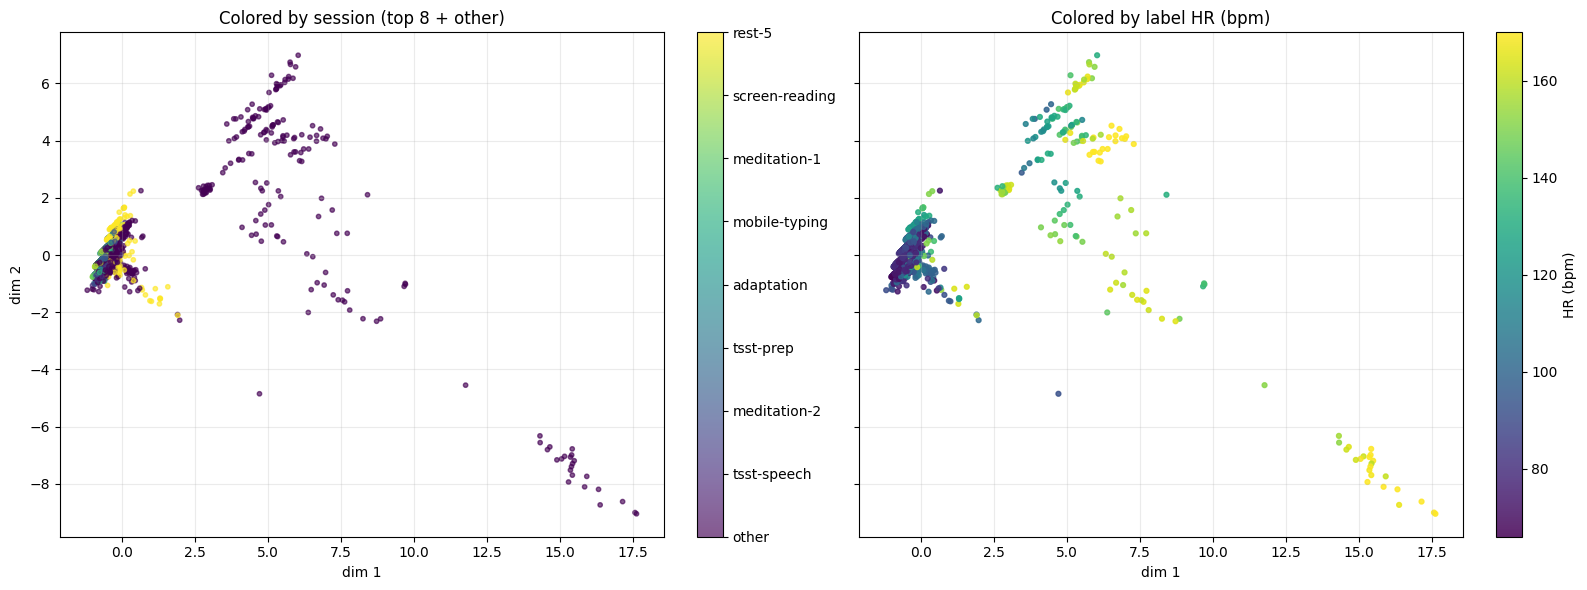

corr(dim1, HR)=0.765 | corr(dim2, HR)=0.287


In [27]:
# Side-by-side: session vs HR coloring
topK = 8
top_sess = feat_df["session"].value_counts().head(topK).index.tolist()
sess_plot = feat_df["session"].where(feat_df["session"].isin(top_sess), other="other")
codes, labels = pd.factorize(sess_plot)

hr = feat_df["y_hr"].astype(float).to_numpy()
mask_hr = np.isfinite(hr)
vmin, vmax = np.nanpercentile(hr[mask_hr], [1, 99])

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

sc0 = ax[0].scatter(Z[:, 0], Z[:, 1], c=codes, s=10, alpha=0.65)
ax[0].set_title(f"Colored by session (top {topK} + other)")
ax[0].set_xlabel("dim 1")
ax[0].set_ylabel("dim 2")
cb0 = fig.colorbar(sc0, ax=ax[0], fraction=0.046)
cb0.set_ticks(range(len(labels)))
cb0.set_ticklabels(labels)

sc1 = ax[1].scatter(
    Z[mask_hr, 0], Z[mask_hr, 1], c=hr[mask_hr], s=12, alpha=0.85, vmin=vmin, vmax=vmax
)
ax[1].set_title("Colored by label HR (bpm)")
ax[1].set_xlabel("dim 1")
fig.colorbar(sc1, ax=ax[1], fraction=0.046).set_label("HR (bpm)")

for a in ax:
    a.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

c1 = float(np.corrcoef(Z[mask_hr, 0], hr[mask_hr])[0, 1])
c2 = float(np.corrcoef(Z[mask_hr, 1], hr[mask_hr])[0, 1])
print(f"corr(dim1, HR)={c1:.3f} | corr(dim2, HR)={c2:.3f}")

PC1 strongly tracks HR (corr ~0.77); confirms dominant-frequency
and bandpower features encode cardiac rate. Sessions overlap in the
embedding but HR varies within that overlap 
-> this is the activity-driven
signal phenotype that motivates multimodal fusion or learned
representations for robust HR estimation.


session,adaptation,meditation-1,meditation-2,mobile-typing,other,rest-5,screen-reading,tsst-prep,tsst-speech
cluster,,,,,,,,,
0,0.14,0.12,0.14,0.07,0.33,0.02,0.07,0.04,0.07
1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,0.01,0.05,0.02,0.01,0.43,0.30,0.02,0.09,0.07
5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
6,0.10,0.10,0.08,0.08,0.39,0.04,0.06,0.09,0.06
7,0.00,0.00,0.00,0.00,0.66,0.34,0.00,0.00,0.00


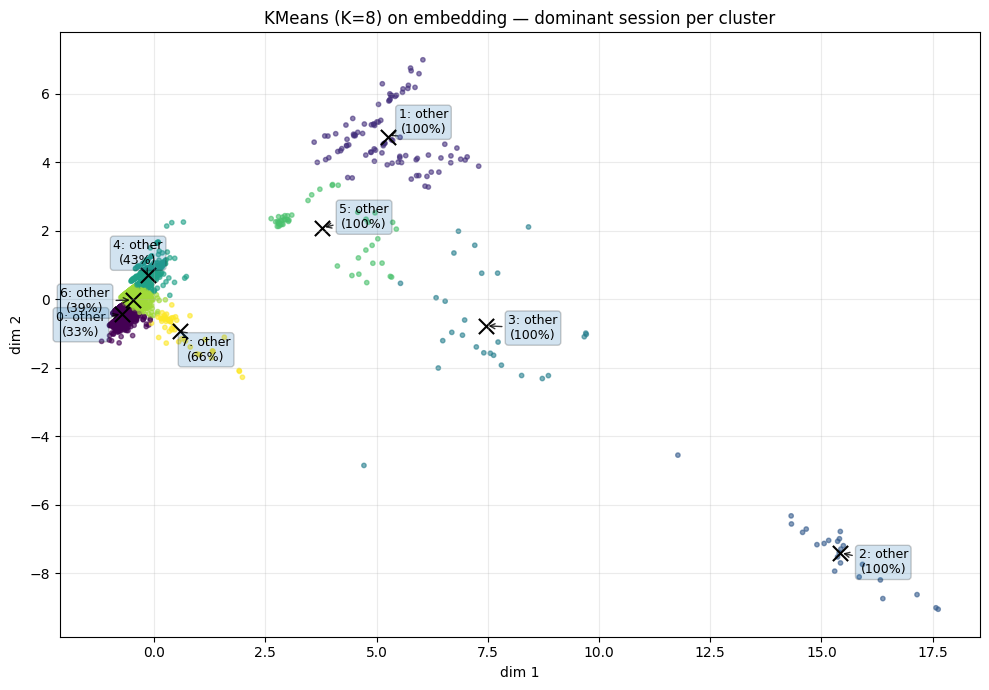

In [28]:
# KMeans clustering + session composition
if SKLEARN_OK:
    K = 8
    cl = KMeans(n_clusters=K, random_state=0, n_init=10).fit_predict(Z)
    cent = KMeans(n_clusters=K, random_state=0, n_init=10).fit(Z).cluster_centers_

    tmp = pd.DataFrame({"cluster": cl, "session": sess_plot.values})
    tab = pd.crosstab(tmp["cluster"], tmp["session"], normalize="index")
    display(tab.style.format("{:.2f}"))

    # Build centroid labels
    clabels = {}
    for k in range(K):
        sub = tmp[tmp["cluster"] == k]
        vc = sub["session"].value_counts(normalize=True)
        clabels[k] = f"{k}: {vc.index[0]}\n({vc.iloc[0]:.0%})" if len(vc) else f"{k}: empty"

    plt.figure(figsize=(10, 7))
    plt.scatter(Z[:, 0], Z[:, 1], c=cl, s=10, alpha=0.6)
    plt.scatter(cent[:, 0], cent[:, 1], s=120, marker="x", c="black")

    cx, cy = np.mean(Z[:, 0]), np.mean(Z[:, 1])
    dx, dy = np.std(Z[:, 0]), np.std(Z[:, 1])
    for k in range(K):
        x, y = cent[k]
        vx, vy = x - cx, y - cy
        norm = np.hypot(vx, vy) + 1e-9
        plt.annotate(
            clabels[k],
            xy=(x, y),
            xytext=(x + 0.5 * dx * vx / norm, y + 0.5 * dy * vy / norm),
            ha="center",
            va="center",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", alpha=0.2),
            arrowprops=dict(arrowstyle="->", lw=1, alpha=0.8),
        )

    plt.title(f"KMeans (K={K}) on embedding — dominant session per cluster")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

## Notes

- MAE ~13 bpm is high but expected: 8-second windows give few beats for
  stable peak-based HR, the dicrotic notch fools naive peak pickers, and
  bandpass/prominence thresholds don't generalize well across sessions.

- The coverage-error curve shows that quality gating reliably pushes MAE
  down at the cost of coverage -> a concrete demonstration of why learned
  models (or RLHF-style feedback loops) are needed for the hard windows.

- Session structure in the embedding motivates per-session or
  session-aware training strategies.
